# LOGAN for testing sequential mediation effects

### In the following, we conduct a simulation study to demonstrate the usage of LOGAN for sequential pathway inference. The data generating process is the same as the first simulation scenario in Li, Shi, Guo and Jagust (2021).

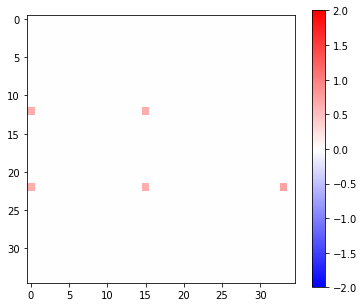

In [1]:
import numpy as np
import scipy
import networkx
import matplotlib.pyplot as plt

import notears.utils as ut
import matplotlib.cm as cm
ut.set_random_seed(123456)
d1 = 35
d2 = d1
p = 70
W, _ = ut.generate_dag_exam1(p, prob=[0.05, 0.1], edge_coefficient_range=[0.6, 1.4])

W_star = abs(W).copy()
W_tem = W_star.copy()
for j in range(p+1):
    for i in range(len(W)):
        W_star[i, :] = np.amax(np.minimum(np.outer(W_star[i, :], np.ones(len(W))), abs(W)), axis=0)
    W_tem = np.maximum(W_tem, W_star)
W_star = W_tem.copy()
strength = np.array([[min(W_star[i,0],W_star[j,i],W_star[p+1,j]) for i in np.arange(1, d1+1)] for j in np.arange(d1+1, p+1)])
cmap = plt.get_cmap('bwr')
cmap.set_bad(color='white')
fig, ax = plt.subplots(figsize=(6,6))
img = ax.imshow(strength, cmap=cmap, vmin=-2, vmax=2)
np.nonzero(strength)
plt.colorbar(img, shrink=0.85)

### We next run L simulations to compute the p-values of the proposed test.

In [2]:
import pycasso
import numpy.random as nr
import notears.notears as nt
from numpy import linalg as LA
import scipy.linalg as slin
# define penalized regression with mcp penalty
def _mcp_reg(y, x, n_sample, p): # p is the number of columns in x
    if p==1:
        x = x.reshape((n_sample,1))
    lambda_list = np.exp(np.arange(-5,3,0.1))
    for j in range(p):
        x[:,j] = x[:,j] - np.mean(x[:,j])
    std = np.sqrt(np.sum(x * x, axis=0))/np.sqrt(n_sample)
    x = x/std
    mcp = pycasso.Solver(x, y-np.mean(y), penalty="mcp", gamma=1.25, prec=1e-4, lambdas=lambda_list)
    mcp.train()
    BIC = np.zeros(len(lambda_list))
    for k in range(len(lambda_list)):
        BIC[k] = np.sum(np.square(y - np.mean(y) - x @ mcp.coef()['beta'][k])) +                         sum(mcp.coef()['beta'][k]!=0)*np.log(n_sample)
    return mcp.coef()['beta'][np.argmin(BIC)]/std

# reestimate the coefficients based on mcp penalized regression
def _refit1(trt, med1, n_sample, d1, W11): 
    W11 = W11.transpose()
    W1_refit = np.zeros((d1+1,d1+1))
    for j in np.arange(1,d1+1):
        Indices = W11[j-1,:]!=0
        W1_refit[j,np.append(True, Indices)] = _mcp_reg(med1[:,j-1], np.c_[trt, med1[:,Indices]], n_sample, sum(Indices)+1)
    return W1_refit

def _refit2(trt, med1, med2, n_sample, d1, d2, W22):
    res2 = med2 - med2@W22
    W22 = W22.transpose()
    W2_refit = np.zeros((d2,d1+d2+1))
    for j in np.arange(0,d2):
        Indices2 = W22[j,:]!=0
        gamma = _mcp_reg(res2[:,j], np.c_[trt, med1], n_sample, d1+1)
        Indices1 = gamma!=0
        Indices1[0] = True
        Indices = np.append(Indices1, Indices2)
        W2_refit[j,Indices] = _mcp_reg(med2[:,j], np.c_[trt, med1, med2][:,Indices], n_sample, sum(Indices))
    return W2_refit

def _refit(trt, med1, med2, res, n_sample, d1, d2, W11, W22):
    W1_refit = _refit1(trt, med1, n_sample, d1, W11)
    W2_refit = _refit2(trt, med1, med2, n_sample, d1, d2, W22)
    W2_refit = np.row_stack((W2_refit, np.zeros([1,d1+d2+1])))
    W2_refit[d2,:] = _mcp_reg(res, np.c_[trt, med1, med2], n_sample, d1+d2+1)
    return W1_refit, W2_refit

n_sample = 200
L = 1
for k in np.arange(1,1+L):
    ut.set_random_seed(12345*k)
    data = ut.simulate_linear_sem(1, W.transpose(), n_sample)
    trt = data[:, 0].reshape(-1)
    med1 = np.copy(data[:,1:(d1+1)])
    med2 = np.copy(data[:,(d1+1):(p+1)])
    res = data[:, p+1].reshape(-1)
    
    ## Step 1: sample splitting 
    import numpy.random as nr
    import notears.notears as nt
    from numpy import linalg as LA
    import scipy.linalg as slin
    ## set random seed
    ut.set_random_seed(12345)
    sample1 = nr.choice(n_sample, int(n_sample/2), replace=False)
    sample2 = [x for x in range(n_sample) if x not in set(sample1)]
    
    ## Step 2: Estimation of W_{1,1}
    # compute residuals
    from sklearn.linear_model import LinearRegression
    med1_re1 = med1[sample1,:].copy()
    med1_re2 = med1[sample2,:].copy()
    for j in range(np.shape(med1_re1)[1]):
        reg = LinearRegression().fit(trt[sample1].reshape(np.shape(sample1)[0],1), med1_re1[:,j])
        med1_re1[:,j] = med1_re1[:,j] - reg.predict(trt[sample1].reshape(np.shape(sample1)[0],1))
    for j in range(np.shape(med1_re2)[1]):
        reg = LinearRegression().fit(trt[sample2].reshape(np.shape(sample2)[0],1), med1_re2[:,j])
        med1_re2[:,j] = med1_re2[:,j] - reg.predict(trt[sample2].reshape(np.shape(sample2)[0],1))   
    # estimate W11
    w=1e-3
    # tuning parameter
    lambda1 = 0.1*np.sqrt(np.log(d1)/(n_sample/2))
    # apply notears
    W111 = nt.notears_linear_l1(med1_re1, lambda1=lambda1, max_iter=2000, loss_type='l2', w_threshold=w) 
    W112 = nt.notears_linear_l1(med1_re2, lambda1=lambda1, max_iter=2000, loss_type='l2', w_threshold=w)
    while True:
        M = np.eye(d1) + W111 * W111 / d1
        E = np.linalg.matrix_power(M, d1-1)
        h = (E.T * M).sum() - d1
        if h<=0:
            break
        else:
            w = 2*w 
            W111[np.abs(W111)<=w] = 0
    w=1e-3
    while True:
        M = np.eye(d1) + W112 * W112 / d1
        E = np.linalg.matrix_power(M, d1-1)
        h = (E.T * M).sum() - d1
        if h<=0:
            break
        else:
            w = 2*w 
            W112[np.abs(W112)<=w] = 0
    
    ## Estimation of W_{2,2}
    # compute residuals
    med2_re1 = med2[sample1,:].copy()
    med2_re2 = med2[sample2,:].copy()
    for j in range(np.shape(med2_re1)[1]):
        gamma = _mcp_reg(med2_re1[:,j], np.c_[trt[sample1], med1_re1], np.shape(sample1)[0], d1+1)
        med2_re1[:,j] = med2_re1[:,j] - np.c_[trt[sample1], med1_re1] @ gamma
        med2_re1[:,j] = med2_re1[:,j] - np.mean(med2_re1[:,j])
    for j in range(np.shape(med2_re2)[1]):
        gamma = _mcp_reg(med2_re2[:,j], np.c_[trt[sample2], med1_re2], np.shape(sample2)[0], d1+1)
        med2_re2[:,j] = med2_re2[:,j] - np.c_[trt[sample2], med1_re2] @ gamma
        med2_re2[:,j] = med2_re2[:,j] - np.mean(med2_re2[:,j])
    
    ## estimate W12
    w=1e-3
    ## tuning parameter
    lambda2 = 0.1*np.sqrt(np.log(d2)/(n_sample/2))
    ## apply notears
    W221 = nt.notears_linear_l1(med2_re1, lambda1=lambda2, max_iter=2000, loss_type='l2', w_threshold=w) 
    W222 = nt.notears_linear_l1(med2_re2, lambda1=lambda2, max_iter=2000, loss_type='l2', w_threshold=w)
    while True:
        M = np.eye(d2) + W221 * W221 / d2
        E = np.linalg.matrix_power(M, d2-1)
        h = (E.T * M).sum() - d2
        if h<=0:
            break
        else:
            w = 2*w 
            W221[np.abs(W221)<=w] = 0
    w=1e-3
    while True:
        M = np.eye(d2) + W222 * W222 / d2
        E = np.linalg.matrix_power(M, d2-1)
        h = (E.T * M).sum() - d2
        if h<=0:
            break
        else:
            w = 2*w 
            W222[np.abs(W222)<=w] = 0
            
    ## Step 4: Refitting the weighted adjancency matrix
    W1_refit1, W2_refit1 = _refit(trt[sample1], med1[sample1,:], med2[sample1,:], res[sample1], np.shape(sample1)[0], d1, d2, W111, W221)
    W1_refit2, W2_refit2 = _refit(trt[sample2], med1[sample2,:], med2[sample2,:], res[sample2], np.shape(sample2)[0], d1, d2, W112, W222)
    W_refit1 = np.row_stack((np.c_[W1_refit1, np.zeros((d1+1,d2))], W2_refit1))
    W_refit1 = np.c_[W_refit1, np.zeros((d1+d2+2,))]
    W_refit2 = np.row_stack((np.c_[W1_refit2, np.zeros((d1+1,d2))], W2_refit2))
    W_refit2 = np.c_[W_refit2, np.zeros((d1+d2+2,))]
    
    np.savetxt('W_refit1'+str(k)+'.csv', W_refit1, delimiter=',')
    np.savetxt('W_refit2'+str(k)+'.csv', W_refit2, delimiter=',')
    print(k)
    
import numpy.random as nr
import notears.notears as nt
from numpy import linalg as LA
import scipy.linalg as slin

## determine the set of ancestors for each node
def _ancestor(W_refit): 
    p = len(W_refit)
    B0 = np.abs(W_refit)>0
    B = B0.copy()
    B_tem = B0.copy()
    for j in range(p-1):
        B = np.dot(B, B0)
        B_tem = np.maximum(B_tem, B)
    B_tem[-1,0:-1] = True
    B_tem[0:-1,0] = True
    return B_tem

## calculate the decorrelated score statistic
def _decor_score(x, W_refit, B, L=1000):
    # B denote the set of ancestors
    n_sample, p = np.shape(x)
    W_ds = W_refit.copy()
    Boot_W = np.zeros((p, p, L))
    for j in range(p):
        x[:,j] = x[:,j] - np.mean(x[:,j])
    for i in np.arange(1,p):
        for j in np.arange(0,p-1):
            if W_refit[i,j]!=0:
                Indices = B[i,:].copy()
                Indices[0] = True
                Indices[i] = False
                Indices[j] = False
                Indices[p-1] = False
                gamma = np.zeros(p)
                if (sum(Indices)>0):
                    gamma[Indices] = _mcp_reg(x[:,j], x[:,Indices], n_sample, sum(Indices))
                tem_vec1 = x[:,j] - x @ gamma
                tem_vec2 = x[:,i] - x @ W_refit[i,:] + x[:,j]*W_refit[i,j]
                W_ds[i,j] = np.dot(tem_vec1, tem_vec2)/np.dot(x[:,j], tem_vec1)
                for l in range(L):
                    Boot_W[i,j,l] = np.dot(tem_vec1, nr.normal(size=n_sample))/np.dot(x[:,j], tem_vec1)
    return W_ds, Boot_W

## calculate W_star
def _W_star(W, p):
    W_star = abs(W).copy()
    W_tem = W_star.copy()
    for j in range(p+1):
        for i in range(len(W)):
            W_star[i, :] = np.amax(np.minimum(np.outer(W_star[i, :], np.ones(len(W))), abs(W)), axis=0)
        W_tem = np.maximum(W_tem, W_star)
    return W_tem.copy()

import pycasso
import numpy.random as nr
import notears.notears as nt
from numpy import linalg as LA
import scipy.linalg as slin
# define penalized regression with mcp penalty
def _mcp_reg(y, x, n_sample, p): # p is the number of columns in x
    if p==1:
        x = x.reshape((n_sample,1))
    lambda_list = np.exp(np.arange(-5,3,0.1))
    for j in range(p):
        x[:,j] = x[:,j] - np.mean(x[:,j])
    std = np.sqrt(np.sum(x * x, axis=0))/np.sqrt(n_sample)
    x = x/std
    mcp = pycasso.Solver(x, y-np.mean(y), penalty="mcp", gamma=1.25, prec=1e-4, lambdas=lambda_list)
    mcp.train()
    BIC = np.zeros(len(lambda_list))
    for k in range(len(lambda_list)):
        BIC[k] = np.sum(np.square(y - np.mean(y) - x @ mcp.coef()['beta'][k])) +sum(mcp.coef()['beta'][k]!=0)*np.log(n_sample)
    return mcp.coef()['beta'][np.argmin(BIC)]/std


# In[ ]:


n_sample = 200
test11 = np.zeros((d1, 2, L))
test21 = np.zeros((d1, d2, 2, L))
test31 = np.zeros((d2, 2, L))
test41 = np.zeros((d1, 2, L))
for k in np.arange(1,1+L):
    ut.set_random_seed(12345*k)
    data = ut.simulate_linear_sem(1, W.transpose(), n_sample)
    trt = data[:, 0].reshape(-1)
    med1 = np.copy(data[:,1:(d1+1)])
    med2 = np.copy(data[:,(d1+1):(p+1)])
    res = data[:, p+1].reshape(-1)
    
    ## sample splitting 
    import numpy.random as nr
    import notears.notears as nt
    from numpy import linalg as LA
    import scipy.linalg as slin
    
    ## set random seed
    ut.set_random_seed(12345)
    sample1 = nr.choice(n_sample, int(n_sample/2), replace=False)
    sample2 = [x for x in range(n_sample) if x not in set(sample1)]
    
    ## load matrices
    W_refit1 = np.loadtxt('W_refit1'+str(k)+'.csv', delimiter=',')
    W_refit2 = np.loadtxt('W_refit2'+str(k)+'.csv', delimiter=',')
    
    critic1 = np.zeros((1000,))
    critic2 = np.zeros((1000,))
    data1 = np.c_[trt, med1, med2, res][sample1,:]
    data2 = np.c_[trt, med1, med2, res][sample2,:]
    sigma1 = np.mean(np.square(data2 - data2 @ W_refit1.transpose()))
    sigma2 = np.mean(np.square(data1 - data1 @ W_refit2.transpose()))
    sigma = np.sqrt((sigma1+sigma2)/2)
    
    ## compute individual p-values
    ## compute p-values using one half of the data
    B1 = _ancestor(W_refit1)
    W_ds2, Boot_W2 = _decor_score(data2, W_refit1, B1)
    W_est_star = _W_star(W_ds2.copy(), d1+d2+2)

    for q1 in np.arange(1, d1+1):
        Ind1 = np.full(d1+d2+2, True)
        Ind2 = np.full(d1+d2+2, True)
        Ind1[B1[q1,:]==False] = False
        Ind1[q1] = True
        Ind1[B1[:,0]==False] = False
        Ind2[B1[:,0]==False] = False
        Ind2[0] = True
        Ind2[B1[q1,:]==False] = False
        for l in range(1000):
            Boot_W = np.copy(Boot_W2[:,:,l])
            Boot_W[W_refit1==0] = 0
            if (sum(Ind1)==0)|(sum(Ind2)==0):
                critic1[l] = 0
            else:
                critic1[l] = np.amax(abs(Boot_W[np.ix_(Ind1,Ind2)]))*sigma  
        test11[q1-1,0,k-1] = np.mean(critic1>=W_est_star[q1,0])

    for q2 in np.arange(d1+1, d1+d2+1):
        Ind1 = np.full(d1+d2+2, True)
        Ind2 = np.full(d1+d2+2, True)
        Ind1[B1[:,q2]==False] = False
        Ind1[0:-1][B1[d1+d2+1,-1]==False] = False
        Ind2[B1[:,q2]==False] = False
        Ind2[q2] = True
        Ind2[B1[d1+d2+1,:]==False] = False
        for l in range(1000):
            Boot_W = np.copy(Boot_W2[:,:,l])
            Boot_W[W_refit1==0] = 0
            if (sum(Ind1)==0)|(sum(Ind2)==0):
                critic1[l] = 0
            else:
                critic1[l] = np.amax(abs(Boot_W[np.ix_(Ind1,Ind2)]))*sigma
        test31[q2-d1-1,0,k-1] = np.mean(critic1>=W_est_star[d1+d2+1,q2])

    for q1 in np.arange(1, d1+1):
        for q2 in np.arange(d1+1, d1+d2+1):
            Ind1 = np.full(d1+d2+2, True)
            Ind2 = np.full(d1+d2+2, True)
            Ind1[B1[q2,:]==False] = False
            Ind1[q2] = True
            Ind1[B1[:,q1]==False] = False
            Ind2[B1[:,q1]==False] = False
            Ind2[q1] = True
            Ind2[B1[q2,:]==False] = False
            for l in range(1000):
                Boot_W = np.copy(Boot_W2[:,:,l])
                Boot_W[W_refit1==0] = 0
                if (sum(Ind1)==0)|(sum(Ind2)==0):
                    critic1[l] = 0
                else:
                    critic1[l] = np.amax(abs(Boot_W[np.ix_(Ind1,Ind2)]))*sigma
            test21[q1-1,q2-d1-1,0,k-1] = np.mean(critic1>=W_est_star[q2,q1])

    for q1 in np.arange(1, d1+1):
        Ind1 = np.full(d1+d2+2, True)
        Ind2 = np.full(d1+d2+2, True)
        Ind1[B1[:,q1]==False] = False
        Ind1[0:-1][B1[d1+d2+1,-1]==False] = False
        Ind2[B1[:,q1]==False] = False
        Ind2[q1] = True
        Ind2[B1[d1+d2+1,:]==False] = False
        for l in range(1000):
            Boot_W = np.copy(Boot_W2[:,:,l])
            Boot_W[W_refit1==0] = 0
            if (sum(Ind1)==0)|(sum(Ind2)==0):
                critic1[l] = 0
            else:
                critic1[l] = np.amax(abs(Boot_W[np.ix_(Ind1,Ind2)]))*sigma
        test41[q1-1,0,k-1] = np.mean(critic1>=W_est_star[d1+d2+1,q1])
    
    ## compute p-values on another set of data
    B2 = _ancestor(W_refit2)
    W_ds1, Boot_W1 = _decor_score(data1, W_refit2, B2)
    W_est_star = _W_star(W_ds1.copy(), d1+d2+2)

    for q1 in np.arange(1, d1+1):
        Ind1 = np.full(d1+d2+2, True)
        Ind2 = np.full(d1+d2+2, True)
        Ind1[B2[q1,:]==False] = False
        Ind1[q1] = True
        Ind1[B2[:,0]==False] = False
        Ind2[B2[:,0]==False] = False
        Ind2[0] = True
        Ind2[B2[q1,:]==False] = False
        for l in range(1000):
            Boot_W = np.copy(Boot_W1[:,:,l])
            Boot_W[W_refit2==0] = 0
            if (sum(Ind1)==0)|(sum(Ind2)==0):
                critic2[l] = 0
            else:
                critic2[l] = np.amax(abs(Boot_W[np.ix_(Ind1,Ind2)]))*sigma  
        test11[q1-1,1,k-1] = np.mean(critic2>=W_est_star[q1,0])

    for q2 in np.arange(d1+1, d1+d2+1):
        Ind1 = np.full(d1+d2+2, True)
        Ind2 = np.full(d1+d2+2, True)
        Ind1[B2[:,q2]==False] = False
        Ind1[0:-1][B2[d1+d2+1,-1]==False] = False
        Ind2[B2[:,q2]==False] = False
        Ind2[q2] = True
        Ind2[B2[d1+d2+1,:]==False] = False
        for l in range(1000):
            Boot_W = np.copy(Boot_W1[:,:,l])
            Boot_W[W_refit2==0] = 0
            if (sum(Ind1)==0)|(sum(Ind2)==0):
                critic2[l] = 0
            else:
                critic2[l] = np.amax(abs(Boot_W[np.ix_(Ind1,Ind2)]))*sigma
        test31[q2-d1-1,1,k-1] = np.mean(critic2>=W_est_star[d1+d2+1,q2])

    for q1 in np.arange(1, d1+1):
        for q2 in np.arange(d1+1, d1+d2+1):
            Ind1 = np.full(d1+d2+2, True)
            Ind2 = np.full(d1+d2+2, True)
            Ind1[B2[q2,:]==False] = False
            Ind1[q2] = True
            Ind1[B2[:,q1]==False] = False
            Ind2[B2[:,q1]==False] = False
            Ind2[q1] = True
            Ind2[B2[q2,:]==False] = False
            for l in range(1000):
                Boot_W = np.copy(Boot_W1[:,:,l])
                Boot_W[W_refit2==0] = 0
                if (sum(Ind1)==0)|(sum(Ind2)==0):
                    critic2[l] = 0
                else:
                    critic2[l] = np.amax(abs(Boot_W[np.ix_(Ind1,Ind2)]))*sigma
            test21[q1-1,q2-d1-1,1,k-1] = np.mean(critic2>=W_est_star[q2,q1])

    for q1 in np.arange(1, d1+1):
        Ind1 = np.full(d1+d2+2, True)
        Ind2 = np.full(d1+d2+2, True)
        Ind1[B2[:,q1]==False] = False
        Ind1[0:-1][B2[d1+d2+1,-1]==False] = False
        Ind2[B2[:,q1]==False] = False
        Ind2[q1] = True
        Ind2[B2[d1+d2+1,:]==False] = False
        for l in range(1000):
            Boot_W = np.copy(Boot_W1[:,:,l])
            Boot_W[W_refit2==0] = 0
            if (sum(Ind1)==0)|(sum(Ind2)==0):
                critic2[l] = 0
            else:
                critic2[l] = np.amax(abs(Boot_W[np.ix_(Ind1,Ind2)]))*sigma
        test41[q1-1,1,k-1] = np.mean(critic2>=W_est_star[d1+d2+1,q1])
            
    print(k)
    
test10 = 2*np.minimum(test11[:,0,:], test11[:,1,:])
test20 = 2*np.minimum(test21[:,:,0,:], test21[:,:,1,:])
test30 = 2*np.minimum(test31[:,0,:], test31[:,1,:])
pvalue = np.zeros((d1,d2,L))
for k in range(L):
    pvalue[:,:,k] = np.array([[max(test10[i,k],test20[i,j,k],test30[j,k]) for i in np.arange(0, d1)] for j in np.arange(0, d2)])

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training is over.
Training i

### Visualise the p-values

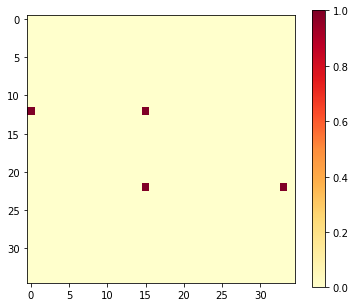

In [3]:
cmap = plt.get_cmap('YlOrRd')
cmap.set_bad(color='white')
fig, ax = plt.subplots(figsize=(6,6))
img = ax.imshow(np.mean(pvalue<=0.05, axis=2), cmap=cmap, vmin=0, vmax=1)
plt.colorbar(img, shrink=0.85)